In [1]:
from pathlib import Path

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from dynamical_systems.continuous import AbstractODE, Lorenz63, TangentODE
from dynamical_systems.transforms import TransformedODE
from dynamics_discovery.dataset import TimeSeriesDataset
from dynamics_discovery.models import NeuralODE
from dynamics_discovery.models.neighborhood import (
    create_neighborhood_dataset,
    NeuralNeighborhoodFlow,
)
from dynamics_discovery.preprocessing import add_noise, standardize
from jaxtyping import Array, Float
from matplotlib_utils.plots import colored_scatterplot


jax.config.update("jax_enable_x64", True)
plt.style.use("matplotlib_utils.styles.dash_gridded")

datadir = Path("../../data")

Consider a state vector $\boldsymbol{x}\in \mathbb{R}^d$ whose dynamics is governed by the ODE
\begin{equation}
\frac{d\boldsymbol{x}}{dt} = f(\boldsymbol{x}).
\end{equation}

The evolution of small deviations $\boldsymbol{\delta x}(t) \in \mathbb{R}^d$ around $\boldsymbol{x}(t)$ is described by the variational equation:
\begin{equation}
\frac{d\boldsymbol{\delta x}}{dt} = \nabla_{\boldsymbol{x}}f(\boldsymbol{x}(t))\boldsymbol{\delta x} = J(\boldsymbol{x})\boldsymbol{\delta x}.
\end{equation}

As this equation is linear with respect to $\boldsymbol{\delta x}$, we can instead consider the following matrix differential equation
\begin{equation}
\frac{d\boldsymbol{M}}{dt} = J(\boldsymbol{x})\boldsymbol{M}, \; \boldsymbol{M}(t=0) = \boldsymbol{I}
\end{equation}
where $\boldsymbol{M}(t;\boldsymbol{x})\in \mathbb{R}^{d\times d}$ is the tangent evolution matrix (or operator), and $\boldsymbol{I}$ is the $d\times d$ identity matrix.

In the vincinity of $\boldsymbol{x}(t)$, the tangent evolution matrix linearly maps the perturbations forward in time:
\begin{equation}
\boldsymbol{\delta x}(t+\tau) = \boldsymbol{M}(\tau;\boldsymbol{x}(t))\boldsymbol{\delta x}(t).
\end{equation}

Thus, when the number of deviations to forecast $m$ is larger than $d$, it is more economical to compute the tangent evolution matrix instead of directly solving the variational equation for the individual perturbations.

In [2]:
dataset_loaded = TimeSeriesDataset.load(datadir / "lorenz63.hdf5")
noise = 0.02
n_steps = 2

t_train = dataset_loaded.t[0]
u_orig = dataset_loaded.u[0]
u_orig = add_noise(u_orig, noise)
u_train, transform = standardize(u_orig)

lorenz_scaled = TransformedODE(Lorenz63(), transform)

In [3]:
def tangent_evolution_matrix(
    ode: AbstractODE,
    x: Float[Array, " dim"],
    t0: float,
    t1: float,
    solver: dfx.AbstractAdaptiveSolver = dfx.Tsit5(),
    stepsize_controller: dfx.AbstractAdaptiveStepSizeController = dfx.PIDController(
        rtol=1e-7, atol=1e-9
    ),
):
    tangent_ode = TangentODE(ode)
    u0 = (x, jnp.identity(ode.dim))

    sol = dfx.diffeqsolve(
        dfx.ODETerm(tangent_ode.rhs),
        solver,
        t0,
        t1,
        None,
        u0,
        None,
        saveat=dfx.SaveAt(t1=True),
        stepsize_controller=stepsize_controller,
    )
    _, M_t = sol.ys
    return M_t[0]  # remove time dimension

In [4]:
M_pred = eqx.filter_vmap(
    lambda u_i: tangent_evolution_matrix(
        lorenz_scaled, u_i, 0.0, t_train[n_steps - 1] - t_train[0]
    )
)(u_train[: -n_steps + 1])

In [5]:
import scipy.signal as scsignal


u_smooth = scsignal.savgol_filter(u_train, window_length=7, polyorder=3, axis=0)
u_smooth.shape

(10000, 3)

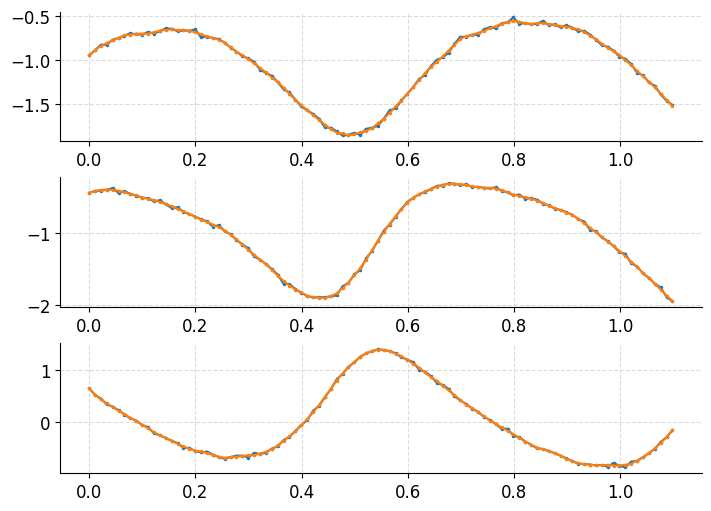

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(7, 5))
for i, ax in enumerate(axes):
    ax.plot(t_train[:100], u_train[:100, i], ".-")
    ax.plot(t_train[:100], u_smooth[:100, i], ".-")

In [7]:
_, _, du, _ = create_neighborhood_dataset(
    t_train,
    u_smooth,
    num_neighbors=30,
    train_length=n_steps,
    train_length_neighbors=n_steps,
    min_radius=0.2,
    max_radius=0.4,
)

In [8]:
du.shape

(9999, 2, 30, 3)

In [9]:
du0, du1 = du[:, 0], du[:, -1]

M_data = jnp.permute_dims((jnp.linalg.pinv(du0) @ du1).T, (2, 0, 1))

In [10]:
du0_test = du0[0]
du0_test.shape

(30, 3)

In [11]:
import itertools


def batched_outer(
    x: Float[Array, "*dims_x"], y: Float[Array, " dim_y"]
) -> Float[Array, "*dims_x dim_y"]:
    """Compute a (batched) outer product between a n(>1)D tensor x and a 1D tensor y.

    For x of shape (i_0, ..., i_{n-1}) and y of shape (j,), the output tensor has the
    shape (i_0, ..., i_{n-1}, j)."""
    return jnp.expand_dims(x, axis=-1) * y


def monomial_basis_unique(x, order: int):
    arr = jnp.asarray(list(itertools.combinations_with_replacement(x, order)))
    return jnp.prod(arr, axis=-1)


def make_monomial_features(x, max_order: int = 2):
    """Given a vector x=[x1,x2,x3], create a 1D vector containing all the monomial
    basis terms upto order n.

    For n=2, this corresponds to [x1, x2, x3, x1^2, x1x2, x1x3, x2x1, x2^2, x2x3, x3x1,
    x3x2, x3^2]"""
    terms = [monomial_basis_unique(x, i) for i in range(1, max_order + 1)]
    return jnp.concatenate(terms)


In [12]:
du0_second_order = jax.vmap(jax.vmap(lambda x: make_monomial_features(x, 3)))(du0)
du0_second_order.shape

(9999, 30, 19)

In [13]:
du0_second_order[0, 0]

Array([ 1.15314194e-01,  1.57277650e-01, -4.86175360e-02,  1.32973634e-02,
        1.81363455e-02, -5.60629199e-03,  2.47362592e-02, -7.64645181e-03,
        2.36366481e-03,  1.53337475e-03,  2.09137807e-03, -6.46485044e-04,
        2.85244180e-03, -8.81744430e-04,  2.72564103e-04,  3.89046072e-03,
       -1.20261597e-03,  3.71751646e-04, -1.14915559e-04], dtype=float64)

In [14]:
M_data2 = jnp.permute_dims((jnp.linalg.pinv(du0_second_order) @ du1).T, (2, 0, 1))[
    ..., :3
]
M_data2.shape

(9999, 3, 3)

In [15]:
err = jnp.linalg.norm(M_pred - M_data, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)
err2 = jnp.linalg.norm(M_pred - M_data2, axis=(-1, -2)) / jnp.linalg.norm(
    M_pred, axis=(-1, -2)
)

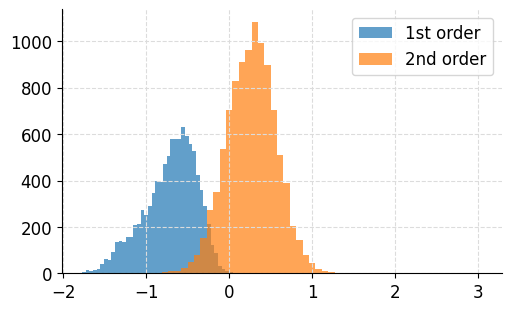

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
ax.hist(jnp.log10(err), bins=50, alpha=0.7, label="1st order")
ax.hist(jnp.log10(err2), bins=50, alpha=0.7, label="2nd order")
ax.legend()

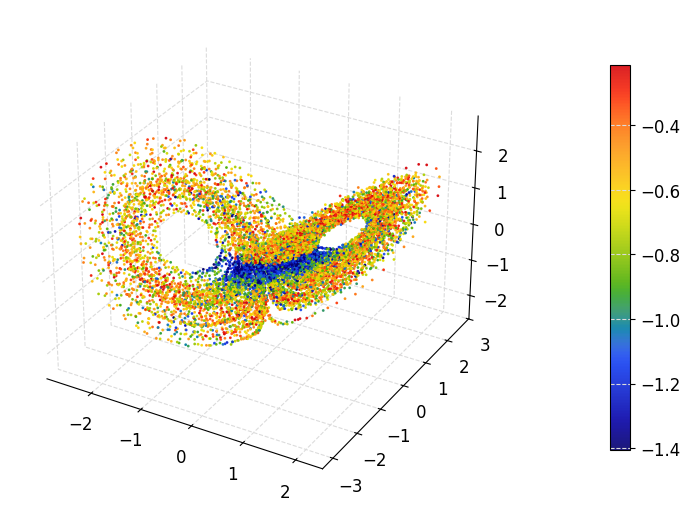

In [17]:
import colorcet as cc
import numpy as np


scatter_kwargs = {
    "s": 1,
    "cmap": cc.cm.rainbow4,
    "vmin": np.percentile(jnp.log10(err), 2.5),
    "vmax": np.percentile(jnp.log10(err), 97.5),
    "alpha": 0.9,
}

fig = colored_scatterplot(
    (u_train[: -n_steps + 1].T,), (jnp.log10(err),), **scatter_kwargs
)

In [ ]:
ode = NeuralODE(3, 32, 3, key=0, solver=dfx.Tsit5(), rtol=1e-4, atol=1e-6)
model = NeuralNeighborhoodFlow(ode, use_seminorm=False, second_order=False)


SyntaxError: positional argument follows keyword argument (2378072622.py, line 1)